#  Summary of what this capstone will, and may accomplish

* Scrape data from indeed, and return job postings
* properly format location, title, requirements (location done, 
* analyze what words and requirements occur the most
* Determine the quality of each job posting (how generic does it sound, and how common are the phrases that they are using) - this is important, but needs a bit of refinement
* Compare correlation between words used and position

Not required, but would be nice to implement
* add input to allow users to specifiy the cities to look at
* add a map to visualize how many postings there are in each city 

Web scraper script can be found at 
https://github.com/mhuh22/Thinkful/blob/master/Bootcamp/Unit%207/Indeed%20Job%20Scraper.ipynb

In [1]:
# Basic imports
import os
import time
import timeit
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning packages
from sklearn import ensemble
from sklearn.feature_selection import chi2, f_classif, SelectKBest 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import normalize

# Natural Language processing
import nltk
import re
import spacy
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_rcv1
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering packages
import sklearn.cluster as cluster
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from scipy.spatial.distance import cdist

# Plotly packages
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
import cufflinks as cf
import ipywidgets as widgets
from scipy import special
py.offline.init_notebook_mode(connected=True)

In [2]:
# Import the dataframe
job_data = pd.read_csv('data/dc_indeed.csv', index_col=False)
job_data.drop(['Unnamed: 0'], 1, inplace=True)

In [3]:
# Let's check up on the size of our dataframe
job_data.shape

(1485, 7)

In [4]:
# Preview the data
job_data

,Title,Location,Company,Salary,Synopsis,Query,Metro
0,Data Analyst,"Washington, DC",Chenega Corporation,None,Perform data entry...,data+analyst,washington+dc
1,Program Data Analyst,"Arlington, VA",RGS,None,Organize and build...,data+analyst,washington+dc
2,Data Scientist - Human Capital Analytics,"Bethesda, MD 20816",Leidos,None,"Review, assess dat...",data+analyst,washington+dc
3,Intelligence Analyst with TS/SCI,"Washington, DC",Object CTalk Inc.,None,Strong analytical ...,data+analyst,washington+dc
4,Systems Analyst/Data Scientist,"Springfield, VA",Radiant Solutions,None,We build advanced ...,data+analyst,washington+dc
5,Aviation Data Systems Analyst,"Washington, DC",Concepts Beyond,None,The Analyst will p...,data+analyst,washington+dc
6,Health Interventions and Claims Data Analyst,"Washington, DC 20007 (Georgetown area)",Innovation Center for Biomedical Infor...,None,We are working on applying data sc...,data+analyst,washington+dc
7,Political Data Service Analyst,"Washington, DC 20005 (Logan Circle area)",Data Trust,None,The Data Services Analyst will be ...,data+analyst,washington+dc
8,Part Time/Full Time Administrative Assistant,"Washington, DC 20003 (Capitol Hill area)",General Dynamics Information Technology,\r\n $16 - $18 an hour,Support Program + Management analy...,data+analyst,washington+dc
9,Contractual Data Analyst (STASI),"Washington, DC 20431 (Foggy Bottom area)",International Monetary Fund,None,Contractual Data Analyst (STASI) (...,data+analyst,washington+dc


In [5]:
# Doing some data cleaning
for i, row in job_data.iterrows():
    
    # Clean up location column to format 'city, state'
    (job_data['Location'][i]) = ' '.join((job_data['Location'][i]).split(' ', 2)[:2]) 
    
    # Clean up summary column (Better, but doesn't completely remove all whitespace)
    (job_data['Synopsis'][i]) = (job_data['Synopsis'][i]).strip()

In [6]:
# Print number of unique categories for all non-numerical columns
job_data.select_dtypes(include=['object']).nunique()

Title       109
Location     30
Company     122
Salary       38
Synopsis    239
Query         3
Metro         1
dtype: int64

In [7]:
# # View all job titles (Not that useful since there are a LOT)
# plt.rcParams['figure.figsize'] = [20,5]
# plt.xticks(rotation=70)
# plt.title('Title Frequency')

# sns.barplot(job_data['Title'].unique(), job_data['Title'].value_counts(), data=job_data)

# Data Visualization

In [8]:
# Print out unique job titles and frequencies
job_data['Title'].value_counts()

Data Scientist                                                  142
Data Analyst                                                    134
Data Engineer                                                    80
Data Scientist - Human Capital Analytics                         31
Graduate Studies Program - Data Scientist                        31
Data Engineer – Entry Level                                      31
Data Analytics Specialist                                        30
Data Engineer - Data Warehousing and ETL                         30
Platform/Data Engineer                                           30
Data Scientist - Entry to Experienced Level                      26
Data Center Engineer                                             25
Sector Data Analyst                                              23
Data Scientist/Data Engineer                                     21
Criminal Justice Research Analyst                                20
DATA ANALYST                                    

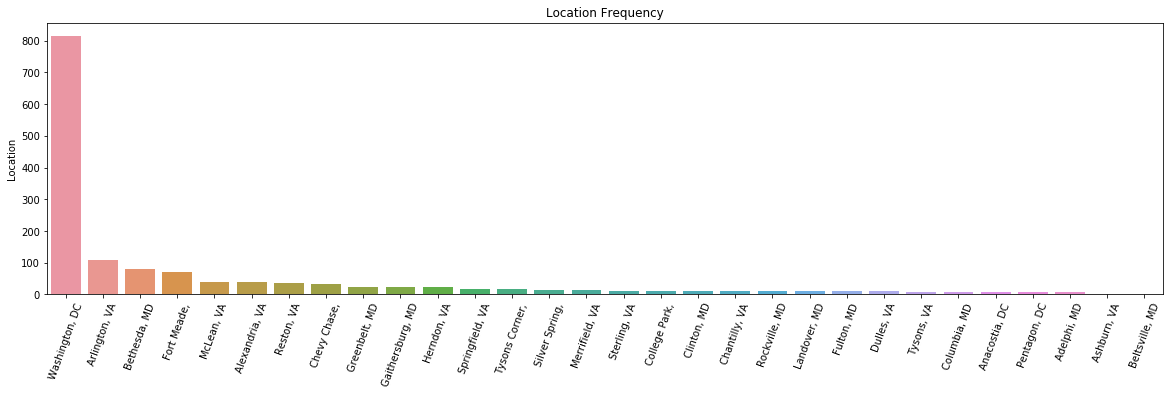

In [9]:
# Plot occurences of each location
# (Not used for anything yet, idk if I'll keep it)
plt.rcParams['figure.figsize'] = [20,5]
plt.xticks(rotation=70)
plt.title('Location Frequency')
x = job_data['Location'].value_counts().index.tolist()
y = job_data['Location'].value_counts()

sns.barplot(x, y, data=job_data)

In [10]:
# Create series with location count
# (Not used for anything yet, idk if I'll keep it)
location_data = job_data['Location'].value_counts()
location_data

Washington, DC      816
Arlington, VA       109
Bethesda, MD         79
Fort Meade,          71
McLean, VA           40
Alexandria, VA       38
Reston, VA           35
Chevy Chase,         32
Greenbelt, MD        25
Gaithersburg, MD     25
Herndon, VA          24
Springfield, VA      16
Tysons Corner,       16
Silver Spring,       15
Merrifield, VA       15
Sterling, VA         11
College Park,        11
Clinton, MD          10
Chantilly, VA        10
Rockville, MD        10
Landover, MD         10
Fulton, MD           10
Dulles, VA           10
Tysons, VA            9
Columbia, MD          9
Anacostia, DC         9
Pentagon, DC          9
Adelphi, MD           9
Ashburn, VA           1
Beltsville, MD        1
Name: Location, dtype: int64

In [11]:
# Cleans up salary data
# (Not sure if I care about salary, but it's here if I need it and it's interesting)

# Create salary dataframe for postings with salary information
salary_data = job_data.replace(to_replace='None', value=np.nan).dropna()

# Cleaning up salary data
salary_data = salary_data[(~salary_data.Salary.str.contains('an hour')) & (~salary_data.Salary.str.contains('a month'))
                   & (~salary_data.Salary.str.contains('a week')) & (~salary_data.Salary.str.contains('a day'))]
salary_data.Salary = salary_data.Salary.str.replace('a year', '').str.replace(',', '').str.replace('$', '')

# Update salary values
new_salaries = []
for i in salary_data.Salary:
    a = i.split('-')
    if len(a) == 2:
        new_salaries.append(np.mean([float(b) for b in a]))
    else:
        new_salaries.append(float(a[0]))        
salary_data.Salary = new_salaries

# Creates boxplots of the occupations
data_analyst = go.Box(
    y=salary_data['Salary'].loc[salary_data['Query']=='data+analyst']
)
data_scientist = go.Box(
    y=salary_data['Salary'].loc[salary_data['Query']=='data+scientist']
)
data_engineer = go.Box(
    y=salary_data['Salary'].loc[salary_data['Query']=='data+engineer']
)
layout = go.Layout(
    title = 'Salary Comparison by Query'
)
data = [data_analyst,data_scientist,data_engineer]
        
fig = go.Figure(data=data,layout=layout)
py.offline.iplot(fig)

<div class="alert alert-block alert-warning">
1. Each salary was computed by converting non-annual salary rates to annual, and taking the average of all ranges. The actual minimum and maximum values are most likely lower and higher respectively.

2. Very few employers (<20%) on Indeed include the salary in the listing (meaning that the numbers shown above are likely higher than the actual numbers.
</div>

In [12]:
# View sample job descriptions
pd.options.display.max_colwidth = 200
job_data['Synopsis'].head(10)

0          Perform data entry and metadata entry for electronic documents. Assist Analyst or Government Official in obtaining/collecting all documents/information to...
1         Organize and build suitable data models. Ability to present data in a logical, concise manner. Ability to synthesize large amounts of data and identify key...
2    Review, assess data, identify data deficiencies and recommend solutions for remediation. Demonstrated experience in developing and applying quantitative methods...
3      Strong analytical skills to interpret data. 5 years (Required). Must be proficient in Microsoft Office applications, Analyst Notebook and message distribution...
4          We build advanced algorithms to gain analytic insights from imagery and geospatial data. Our simulations feed analytic applications so that we can extract...
5                                        The Analyst will play a key role in maintaining data warehousing and data analytical applications for key FAA data

# Text Cleaning

In [13]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [14]:
# Remove annoying punctuation from the articles
job_data['Synopsis'] = job_data.Synopsis.map(lambda x: text_cleaner(str(x)))
job_data['Synopsis'].head()

0          Perform data entry and metadata entry for electronic documents. Assist Analyst or Government Official in obtaining/collecting all documents/information to...
1         Organize and build suitable data models. Ability to present data in a logical, concise manner. Ability to synthesize large amounts of data and identify key...
2    Review, assess data, identify data deficiencies and recommend solutions for remediation. Demonstrated experience in developing and applying quantitative methods...
3      Strong analytical skills to interpret data. 5 years (Required). Must be proficient in Microsoft Office applications, Analyst Notebook and message distribution...
4          We build advanced algorithms to gain analytic insights from imagery and geospatial data. Our simulations feed analytic applications so that we can extract...
Name: Synopsis, dtype: object

# Natural Language Processing

In [15]:
lemmatizer = WordNetLemmatizer()

# Reduce all text to their lemmas
for summary in job_data['Synopsis']:
    summary = lemmatizer.lemmatize(summary)

In [16]:
# Predict job title using text data
X = job_data['Synopsis']
y = job_data['Query']

# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Tf-idf vectorizer

In [17]:
# Parameters for TF-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=5, 
                             max_features=150, 
                             stop_words='english', 
                             lowercase=True, 
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

#Applying the vectorizer
X_tfidf=vectorizer.fit_transform(X)
print("Number of features: %d" % X_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)

#Removes all zeros from the matrix
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Normalize the dataset    
X_norm = normalize(X_train_tfidf)

# Convert from tf-idf matrix to dataframe
X_normal  = pd.DataFrame(data=X_norm.toarray())

Number of features: 150


### Spacy

In [18]:
# Instantiating spaCy
nlp = spacy.load('en')
X_train_words = []

for row in X_train:
    # Processing each row for tokens
    row_doc = nlp(row)
    # Calculating length of each sentence
    sent_len = len(row_doc) 
    # Initializing counts of different parts of speech
    advs = 0
    verb = 0
    noun = 0
    adj = 0
    for token in row_doc:
        # Identifying each part of speech and adding to counts
        if token.pos_ == 'ADV':
            advs +=1
        elif token.pos_ == 'VERB':
            verb +=1
        elif token.pos_ == 'NOUN':
            noun +=1
        elif token.pos_ == 'ADJ':
            adj +=1
    # Creating a list of all features for each sentence
    X_train_words.append([row_doc, advs, verb, noun, adj, sent_len])

# Create dataframe with count of adverbs, verbs, nouns, and adjectives
X_count = pd.DataFrame(data=X_train_words, columns=['BOW', 'ADV', 'VERB', 'NOUN', 'ADJ', 'sent_length'])

# Change token count to token percentage
for column in X_count.columns[1:5]:
    X_count[column] = X_count[column] / X_count['sent_length']

# Normalize X_count
X_counter = normalize(X_count.drop('BOW',axis=1))
X_counter  = pd.DataFrame(data=X_counter)

In [19]:
# Combine tf-idf matrix and phrase count matrix
features = pd.concat([X_counter,X_normal], ignore_index=False, axis=1)
features.head()

,0,1,2,3,4,0,1,2,3,4,...,140,141,142,143,144,145,146,147,148,149
0,0.0,0.003199,0.019196,0.001600,0.999809,0.0,0.309024,0.0,0.263049,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.371803,0.000000,0.0,0.0
1,0.0,0.003781,0.007561,0.003781,0.999957,0.0,0.000000,0.0,0.000000,0.207508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.0,0.007999,0.011199,0.004799,0.999894,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.0,0.005859,0.004883,0.000977,0.999970,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.241028,0.0,0.0
4,0.0,0.005859,0.004883,0.000977,0.999970,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.241028,0.0,0.0


In [20]:
# Calulate predicted values
kmeans = KMeans(n_clusters=job_data['Query'].nunique(), init='k-means++', random_state=42, n_init=20)
y_pred1 = kmeans.fit_predict(features)

pd.crosstab(y_train, y_pred1)

col_0,0,1,2
Query,,,
data+analyst,92,220,65
data+engineer,279,23,55
data+scientist,118,43,218


In [21]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train, y_pred1)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(features, y_pred1, sample_size=60000, metric='euclidean')))

Adjusted Rand Score: 0.2159095
Silhouette Score: 0.04041315


In [22]:
X_train_cluster = pd.DataFrame(features)
X_train_cluster['kmeans'] = y_pred1

### Tf-idf Matrix

In [23]:
# Creating tf-idf matrix
vectorizer = TfidfVectorizer(stop_words='english')
synopsis_tfidf = vectorizer.fit_transform(job_data['Synopsis'])

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=job_data['Query'].nunique()

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 50

In [24]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Parameters for LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Time and run LSA model
start_time = timeit.default_timer()
synopsis_lsa = lsa.fit_transform(synopsis_tfidf)
elapsed_lsa = timeit.default_timer() - start_time

# Extract most common words for LSA
components_lsa = word_topic(synopsis_tfidf, synopsis_lsa, terms)
topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                

In [25]:
from sklearn.decomposition import NMF

# Parameters for NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )

# Time and run NNMF model
start_time = timeit.default_timer()
synopsis_nmf = nmf.fit_transform(synopsis_tfidf)
elapsed_nnmf = timeit.default_timer() - start_time

# Extract most common words for NNMF
components_nmf = word_topic(synopsis_tfidf, synopsis_nmf, terms)
topwords['NNMF']=top_words(components_nmf, n_top_words)

In [26]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                   LSA                NNMF
0          data 151.96          data 12.69
0        analyst 51.37        analyst 6.22
0      experience 45.4      analytics 4.58
0      analytics 44.55      experience 4.4
0       engineer 30.35       analysis 2.95
0       analysis 29.61     collection 2.87
0     management 25.76        systems 2.58
0          years 25.19          years 2.39
0           work 23.49          hands 2.28
0        science 22.92       projects 2.25
0    statistical 21.98         assist 2.17
0       learning 21.78       business 2.05
0        machine 20.86        related 2.03
0           team 20.81       maintain 1.99
0     collection 19.99      management 1.9
0  visualization 19.59  documentation 1.88
0          using 19.15        science 1.84
0        working 19.12          using 1.81
0        systems 18.81        working 1.66
0        business 18.8    statistical 1.64
0      scientist 18.16  visualization 1.57
0     scientists 18.07       learning 1.54
0 

# Training the Model

### Random Forest

In [27]:
rfc = ensemble.RandomForestClassifier()
rfc_train = cross_val_score(rfc, features, y_train, cv=5, n_jobs=-1)
print('Random forest classifier score (without clustering): {:.5f}(+/- {:.2f})\n'.format(rfc_train.mean(), rfc_train.std()*2))

rfc_train_c = cross_val_score(rfc, X_train_cluster, y_train, cv=5, n_jobs=-1)
print('Random forest classifier score (with clustering): {:.5f}(+/- {:.2f})'.format(rfc_train_c.mean(), rfc_train_c.std()*2))

Random forest classifier score (without clustering): 0.95866(+/- 0.03)

Random forest classifier score (with clustering): 0.95953(+/- 0.02)


### Logistic Regression

In [28]:
lr = LogisticRegression()
lr_train = cross_val_score(lr, features, y_train, cv=5, n_jobs=-1)
print('Logistic regression score (without clustering): {:.5f}(+/- {:.2f})\n'.format(lr_train.mean(), lr_train.std()*2))

lr_train_c = cross_val_score(lr, X_train_cluster, y_train, cv=5, n_jobs=-1)
print('Logistic regression score (with clustering): {:.5f}(+/- {:.2f})'.format(lr_train_c.mean(), lr_train_c.std()*2))

Logistic regression score (without clustering): 0.92177(+/- 0.02)

Logistic regression score (with clustering): 0.92177(+/- 0.02)


### Gradient Boosting

In [29]:
gbc = ensemble.GradientBoostingClassifier()
gbc_train = cross_val_score(gbc, features, y_train, cv=5, n_jobs=-1)
print('Gradient boosting classifier score (without clustering): {:.5f}(+/- {:.2f})\n'.format(gbc_train.mean(), gbc_train.std()*2))

gbc_train_c = cross_val_score(gbc, X_train_cluster, y_train, cv=5, n_jobs=-1)
print('Gradient boosting classifier score (with clustering): {:.5f}(+/- {:.2f})'.format(gbc_train_c.mean(), gbc_train_c.std()*2))

Gradient boosting classifier score (without clustering): 0.95865(+/- 0.02)

Gradient boosting classifier score (with clustering): 0.95955(+/- 0.02)
